In [2]:
import numpy as np
import matplotlib.pyplot as plt
from len import bool_conv, inv_bool_conv, finite_len_ab
from scipy.special import erfinv, erf
from scipy.optimize import root_scalar

# Finite Length Approximation

**A** model with $\alpha = 0.5$.

Finding the zero length genome regime

In [3]:
def compute_padding(extra_repl_p:float, alpha:float, n:int): #, p:float)->int:
    """
    Compute the extra margin which reduces the upper
    bound on s.

    ### Parameters
    - extra_repl_p (float):
    - alpha (float) :
    - n (int) : The full length of the string
    """
    assert extra_repl_p <=0.5 and extra_repl_p >=0
    assert alpha <=0.5
    inve = erfinv(extra_repl_p*2)
    coeff = (1-alpha)*np.sqrt(2)/(4*n)
    return inve * coeff

In [4]:
## Defining the parameters
finiteapprox =finite_len_ab()
p = 0.05
n0 = 110
ALPHA = 0.5
qh_min = 1/2*(1-ALPHA) ## comes from the condition on alpha
n = n0/(1-ALPHA)

Initialised the finite length class


In [5]:
NPTS = 200 # Number of qhats's and r for the gridsearch
qh = np.linspace(qh_min+0.01, 0.5, NPTS)
r = np.linspace(p, 0.499, NPTS)
s_min = np.zeros((NPTS, NPTS))
l_min = np.zeros((NPTS, NPTS))
s = np.linspace(0, 0.5, NPTS)

Compute the "padding" for the mean condition. 

In [6]:
p_repl = 0.5
pad = compute_padding(p_repl-0.5,ALPHA, n )
print(pad)
print( 0.5*(1 + erf(4*pad*n/(np.sqrt(2) * (1-ALPHA)))))

0.0
0.5


Compute the minimum $l$ for each $r$ and $\hat{q}$, varying s

In [7]:
for i, rr in enumerate(r):
    for j , qq in enumerate(qh):
        q_tmp = bool_conv(p,bool_conv(qq, p))
        rh = inv_bool_conv(p, rr)
        # print(rh)
        sm = min(1-(1-2*(qq-pad))/ALPHA, 2*rh ) # bool_conv(rh, rh))
        assert np.isscalar(sm)
        s  = np.linspace(0, sm, num = NPTS )
        l_s = finiteapprox.len(q = q_tmp, n0 = n0, p = p,
                            r= rr, s = s, alpha=ALPHA)
        assert l_s.shape == s.shape
        
        minind = np.argmin( l_s )
        assert np.isscalar(minind)
        s_min[i, j] = s[minind]
        l_min[i, j] = l_s[minind]

In [8]:
## Getting the masked array where l_min <=0
Q, R  = np.meshgrid(qh ,r)
mask = l_min <=0
Z = np.ma.masked_array(l_min, mask)

**Find the $r$,$\hat{q}$ and $s_{min}$ corresponding to minimum $r$ with $l_{min} =0$**

In [9]:
## computing the lowest r for <0 genome
lowest_inds = np.any(Z.mask, axis=1)
# print(lowest_inds.shape)
rmin = r[lowest_inds][0]
qind = Z.mask[lowest_inds,:][0]
# print(Z.mask[lowest_inds,:][0])
qpick = qh[qind][0]
spick = s_min[lowest_inds,:][0]
spick = spick[qind][0]
print(spick)
print(qpick)
print(rmin)

0.4355778894472362
0.35889447236180905
0.46064321608040204


Text(0.5, 0.98, '$p_{repl} = $0.5, p = 0.05, $\\alpha= $0.5')

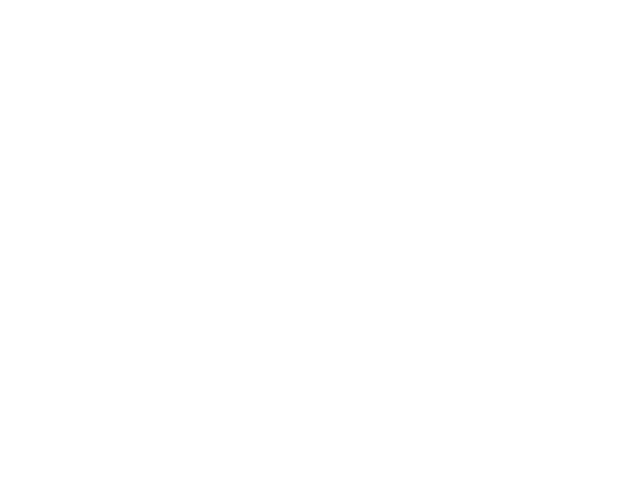

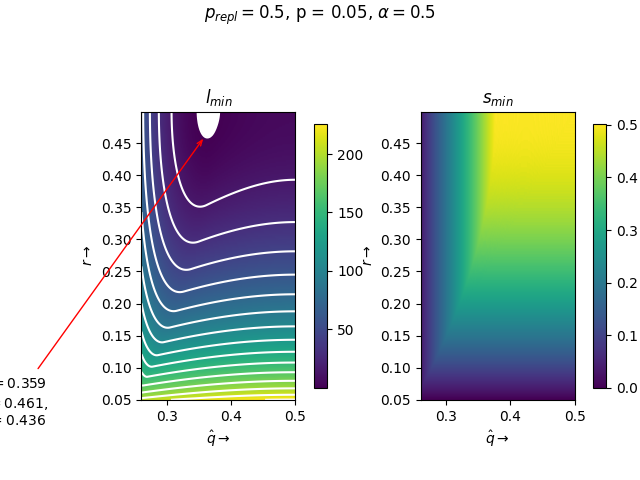

In [10]:
%matplotlib widget
plt.clf()
fig, axs = plt.subplots(1, 2 , constrained_layout = True)
map = axs[1].imshow(s_min, origin = 'lower', extent=[qh[0], qh[-1], r[0], r[-1]])#, aspect='square')
axs[1].set_title(r'$s_{min}$')
plt.colorbar(mappable= map, ax = axs[1],  shrink = 0.6)
map = axs[0].imshow(Z, origin = 'lower', extent=[qh[0], qh[-1], r[0], r[-1]] ) #, aspect='square')
plt.colorbar(mappable= map, ax = axs[0], shrink = 0.6)
# axs[0].imshow(mask, cmap = 'grey', origin = 'lower', extent=[q[0], q[-1], r[0], r[-1]], aspect = 'equal', alpha = 0.5)

axs[0].contour(Q,R, l_min, colors = ['white'], levels = 20)
axs[0].annotate(r'$\hat{q} = $' + f'{qpick:.3f}'
                +'\n'+ r'$r = $' + f'{rmin:.3f},'
                +'\n'+ r'$s= $' + f'{spick:.3f}',
                xy = (qpick, rmin),
                xytext = (0.01, 0.01),
                arrowprops=dict(arrowstyle='->,head_width=.15',color='red')
                )
axs[0].set_title(r'$l_{min}$')
axs[0].set_xlabel(r'$\hat{q}\to$')
axs[0].set_ylabel(r'$r\to$')

axs[1].set_xlabel(r'$\hat{q}\to$')
axs[1].set_ylabel(r'$r\to$')
fig.suptitle(r"$p_{repl} = $"+ f"{p_repl}, p = {p}, "+ r"$\alpha= $" + f'{ALPHA}')
# plt.savefig('../work-docs/gridsearch.png', dpi = 300, bbox_inches = 'tight')
# plt.show()

### Using the picked $r$,$\hat{q}$ and $s_{min}$ to generate random strings

In [11]:
## defining the constants for the problem
s_min = spick
r_min = rmin
qhat_pick_ = qpick
p_dev= p
n0_ = n0

In [18]:
q_ = bool_conv(p_dev, bool_conv(qhat_pick_,p_dev))
n = int(n0_/(1-ALPHA))
k = np.ceil(n*(1- finiteapprox.BinaryH(q_, n)))
print(f'k is {k}')
num_str = int(2**k) #* 16 
print(f'the number of strings are {num_str}')
choice_p = 0.5 # the probability of generating a 1 from the source if it is generated from the binomial


k is 13.0
the number of strings are 8192


In [19]:
# Generating the random fixed points strings
fp_strings = np.random.choice(a = [False, True], size = (num_str, n), p = (1- choice_p, choice_p)) 
print(f' The shape of the string matrix {fp_strings.shape}')
print(f' The memory occupied of the string matrix {fp_strings.nbytes} bytes')


# Generating a random target string with alpha* n length
target_string = np.random.choice( a = [ False, True], size = (n-n0_,), p = [1 -choice_p, choice_p] )

# Getting s and rh_l(left)  and rh_r (right)
STEP = int(ALPHA*n)
cmp_left_right = np.logical_xor(fp_strings[:, :int(ALPHA*n)], fp_strings[:, int(ALPHA*n): int(ALPHA*2*n)])
assert cmp_left_right.shape[0] == num_str
print(f'cmp left right shape {cmp_left_right.shape}')
s_arr = np.sum( cmp_left_right, axis = 1) /(ALPHA*n)
print(f's_arr shape {s_arr.shape}')

target_dist_1 = np.sum( np.logical_xor(target_string, fp_strings[:,:STEP]), axis= 1)
target_dist_2 = np.sum( np.logical_xor(target_string, fp_strings[:,STEP:2*STEP]), axis= 1)
print(target_dist_1.shape)
print(target_dist_2.shape)

# concatenated = np.random.choice( a = [ False, True], size = (n0_,), p = [1 -choice_p, choice_p] )
target_string = np.hstack((target_string, target_string))

rhat_arr = np.where( target_dist_1 >target_dist_2, target_dist_1, target_dist_2)/(STEP)
print(rhat_arr.shape)
# del target_dist_1, target_dist_2, cmp_left_right
print(f'Target String Shape {target_string.shape}')

 The shape of the string matrix (8192, 220)
 The memory occupied of the string matrix 1802240 bytes
cmp left right shape (8192, 110)
s_arr shape (8192,)
(8192,)
(8192,)
(8192,)
Target String Shape (220,)


In [20]:
## find the (boundary) curve
def root(rh, s, k, n):
    probs = np.array([1 - rh - s/2, s/2, s/2 , rh -s/2])
    # print('ps:',probs)
    return (k/n) + finiteapprox.H_n(probs,n, 4) - 2
    # return (k/n) + H(probs) - 2

s_plt = list()
r_plt = list()
# pad = compute_padding(PREPL - 0.5, ALPHA, n)
smax = 1 - (1-2*(qhat_pick_-pad))/ALPHA
s_check = np.linspace(np.min(s_arr), smax , 100)
print(f' args ( k, n0_) {( k, n0_)}')
for ss in (s_check):
    #args = (ss, k, ALPHA, n)
    args = (ss, k, n0_)
    #print(f'Sol args: {args}')
    fun = lambda x:root(x, *args)
    try:
        sol =root_scalar(fun, bracket= (ss/2, 0.5))
        if sol.converged:
            s_plt.append(ss)
            r_plt.append(sol.root)
    except ValueError:
        continue
#arg_inds = np.argsort(s_plt)
s_plt = np.array(s_plt)#[arg_inds]
r_plt = np.array(r_plt)#[arg_inds]


 args ( k, n0_) (np.float64(13.0), 110)


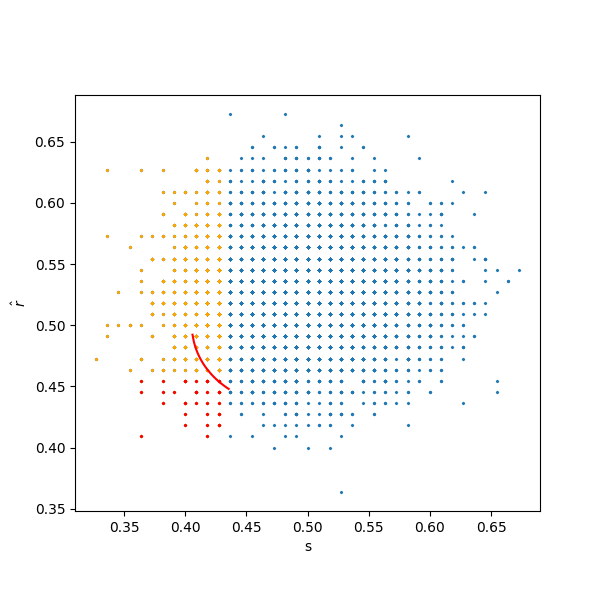

In [21]:
# Plot 
inds_other = s_arr/4 + 0.25 <=qhat_pick_
ind = s_arr <= s_min
size = 2
ind2 = np.logical_and(ind, rhat_arr<=r_min)

plt.figure(figsize=(6,6))
plt.scatter( s_arr, rhat_arr, s = size, marker='x')

plt.scatter( s_arr[ind], rhat_arr[ind], s = size, marker='x',color = 'orange')
# plt.scatter( s_arr[inds_other], rhat_arr[inds_other], s = size, marker='x',color = 'violet')
plt.scatter( s_arr[ind2], rhat_arr[ind2], s = size, color = 'red', marker='x')
plt.plot(s_plt, r_plt, color = 'red')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel(r's')
plt.ylabel(r'$\hat{r}$')
plt.savefig('random_strings_rvs.png', dpi = 300)
plt.show()

In [22]:
# Find the worst alloed s and minimimum rhat string
assert s_arr.shape == rhat_arr.shape
worst_s_arr = np.max(s_arr[ind])
get_worst_s_ind = s_arr == worst_s_arr
get_best_r_in = rhat_arr == np.min(rhat_arr[s_arr == worst_s_arr])
get_index = np.logical_and(get_worst_s_ind, get_best_r_in)
numgiven = np.sum(get_index)


In [23]:
CONSTR_TARG = target_string
if numgiven >1:
    GIVENSTR = np.squeeze(fp_strings[get_index, :][0])
else:
    GIVENSTR = np.squeeze(fp_strings[get_index, :][0])
print(GIVENSTR.shape)
assert GIVENSTR.ndim ==1
print("Assumed that alpha is half, so change the code\
      carefully if it's not the case")

(220,)
Assumed that alpha is half, so change the code      carefully if it's not the case


In [ ]:
## TODO: Add developmental noise here

L = 1000
dists_from_other = np.zeros(L)
dists_from_given = np.zeros(L)
dists_from_target = np.zeros(L)
# left_substr = GIVENSTR[:n//4]
# right_substr = GIVENSTR[3*n//4:n]

# Adding developmental noise to the string to get the Reference string
dev_noise_str = np.random.random(size=GIVENSTR.shape) <= p_dev
REF_STR = np.logical_xor(GIVENSTR, dev_noise_str)
left_substr = REF_STR[:n//4]
right_substr = REF_STR[3*n//4:n]

assert left_substr.shape == right_substr.shape
for l in range(L):
    random_part = np.random.choice(
        a = [True, False],
        size = (n0_,),
        p = [choice_p, 1- choice_p]
        )
    dev_noise_str = np.random.random(size=GIVENSTR.shape) <= p_dev
    CONSTR_STR = np.hstack((left_substr, right_substr, random_part) )
    CONSTR_STR = np.logical_xor(CONSTR_STR, dev_noise_str)
    minm = np.inf
    for i, a_str in enumerate(fp_strings):
        assert a_str.shape == CONSTR_STR.shape
        dist = np.sum(np.logical_xor(CONSTR_STR, a_str))
        minm = min(dist, minm)

    dist = np.sum(np.logical_xor(REF_STR, CONSTR_STR)) 
    dists_from_given[l] = dist/n
    dists_from_other[l] = minm/n
    dists_from_target[l] = np.sum(np.logical_xor(CONSTR_TARG, CONSTR_STR))

indices = dists_from_given >dists_from_other
n_indices = np.logical_not(indices)

print(f'# Successful Replication {np.sum(n_indices)}, Rate = {np.sum(n_indices)/n_indices.shape[0]}')
print(f'# Death {np.sum(indices)}, Rate = {np.sum(indices)/indices.shape[0]}')
print('----')

# Successful Replication 199, Rate = 0.199
# Death 801, Rate = 0.801
----


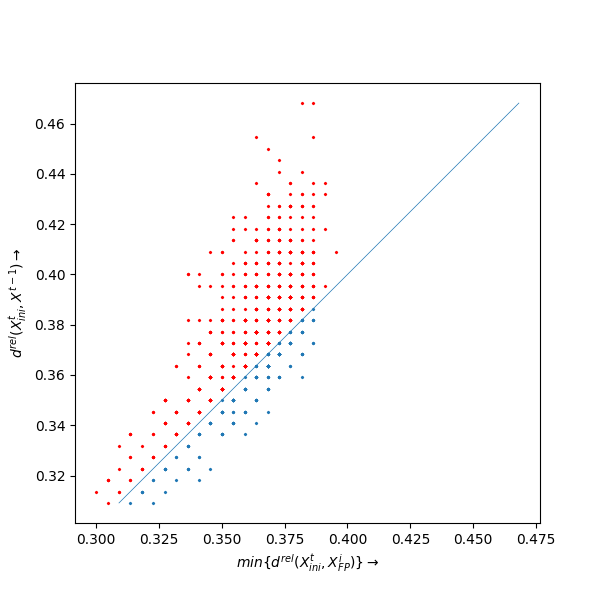

In [31]:
plt.cla()
plt.gca().set_aspect('equal')
x = np.linspace(np.min(dists_from_given), dists_from_given.max(), L )

plt.scatter( dists_from_other[indices], dists_from_given[indices], s= 2, marker='x', color = 'red')
plt.scatter( dists_from_other[n_indices], dists_from_given[n_indices], s= 2, marker='x')

plt.ylabel(r'$d^{rel}(X^t_{ini},X^{t-1})\to$') 
plt.xlabel(r'$min\{d^{rel}(X^t_{ini},X^i_{FP})\}\to$') 

plt.plot(x,x, linewidth =0.5)
plt.savefig('death_repl.png', dpi = 300, bbox_inches ='tight')
plt.show()